# Column-action method of Cordell (1992) - $\mathtt{C92}$

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image

import numpy as np
import pickle

# 3D visualization
import pyvista as pv

from gravmag import plot_functions as plf
from gravmag import inverse_distance as idist
from gravmag import eqlayer as eql
from gravmag import convolve as conv
from gravmag import constants as cts

### Data points

In [2]:
with open('data_points.pickle', 'rb') as f:
    data_points = pickle.load(f)

In [3]:
# number of points along x and y
print(data_points['shape'])

# minimum x, maximum x, minimum y and maximum y
print(data_points['area'])

(50, 50)
[-5000, 5000, -4000, 6000]


In [4]:
# Grid spacing
dx = (data_points['area'][1] - data_points['area'][0])/(data_points['shape'][0]-1)
dy = (data_points['area'][3] - data_points['area'][2])/(data_points['shape'][1]-1)

In [5]:
dx, dy

(204.08163265306123, 204.08163265306123)

In [6]:
# total number of data
D = np.prod(data_points['shape'])

In [7]:
D

2500

### Noise-free gravity data

In [8]:
with open('gravity_data.pickle', 'rb') as f:
    gravity_data = pickle.load(f)

### Noise-corrupted gravity data

In [9]:
with open('gravity_data_noisy.pickle', 'rb') as f:
    gravity_data_noisy = pickle.load(f)

### Set the equivalent sources location

In [10]:
# depth of the equivalent layer
Delta_z = 3*dx
z_layer = data_points['coordinates']['z'][0] + Delta_z

In [11]:
Delta_z, z_layer

(612.2448979591837, 512.2448979591837)

In [12]:
# define source_points as a shallow copy of data_points, i.e., the elements
# at each key are not copies
source_points = data_points['coordinates'].copy()
# set a new 'z' key for source_points
source_points['z'] = np.zeros_like(data_points['coordinates']['z']) + z_layer

### Compute the sensitivity matrix

In [13]:
# kernel matrix associated with the equivalent layer
R2 = idist.sedm(data_points=data_points['coordinates'], source_points=source_points)
G = cts.GRAVITATIONAL_CONST*cts.SI2MGAL*(
    idist.grad(data_points=data_points['coordinates'], source_points=source_points, SEDM=R2, components=['z'])[0]
)

### Estimate the physical-property distribution

In [15]:
# physical-property distribution
convergence, parameters = eql.method_column_action_C92(
        sensitivity_matrix=G, data=gravity_data_noisy['d20'], data_points=data_points['coordinates'],
        zlayer=z_layer, epsilon=1e-3, ITMAX=int(10*D), check_input=True
    )

In [16]:
iterations = [i for i in range(len(convergence))]

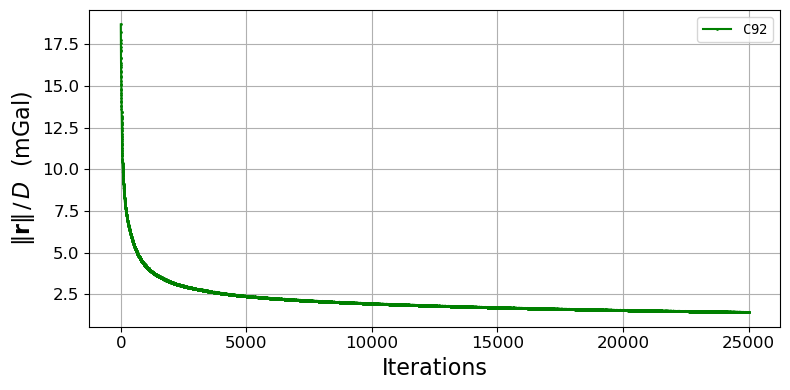

In [17]:
fig, ax = plt.subplots(figsize=(8,4))

# ax.semilogy(iterations, convergence, linestyle='-', 
#             color='purple', marker='^', alpha=1, markersize=4, label='$\mathtt{TOB20}$')
ax.plot(iterations, convergence, linestyle='-', 
        color='green', marker='8', alpha=1, markersize=1, label='$\mathtt{C92}$')

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xlabel('Iterations', fontsize=16)
ax.set_ylabel('$\Vert \mathbf{r} \Vert \, \slash \, D$  (mGal)', fontsize=16)
ax.grid(True)
ax.legend(loc='best', fontsize=10)
plt.tight_layout()
#plt.savefig('../manuscript/Fig/convergence_C92.png', dpi= 300)
plt.show()

In [18]:
predicted_data = dict()

In [19]:
# data predicted by the estimated equivalent layer
predicted_data['gz'] = G@parameters

In [20]:
# residuals vector
residuals_data = predicted_data['gz'] - gravity_data_noisy['d20']

### Plot the data fit

In [21]:
ranges_data = np.max(np.abs(gravity_data_noisy['d20']))
ranges_res = np.max(np.abs(residuals_data))

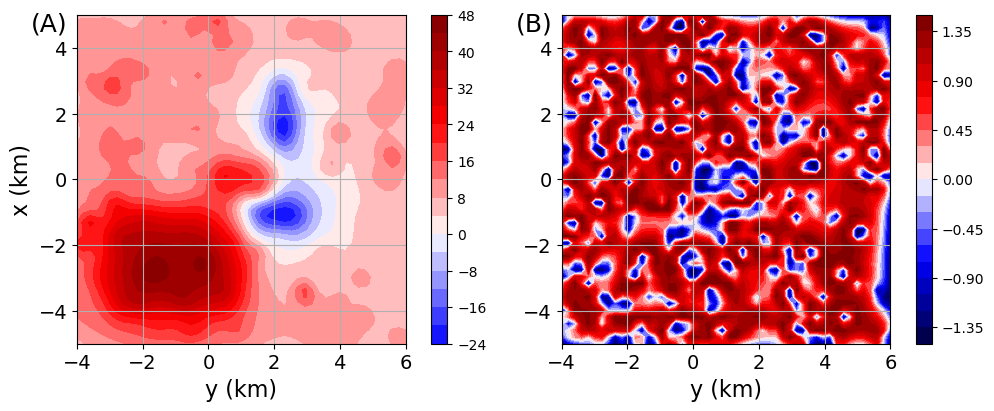

In [22]:
fig = plt.figure(layout= 'constrained', figsize=(10,4))
mosaic = fig.subplot_mosaic('''
                            ab
                            ''')
ax = mosaic['a']
ax.axis('scaled')
im = ax.contourf(data_points['coordinates']['y'].reshape(data_points['shape'])*0.001, 
                 data_points['coordinates']['x'].reshape(data_points['shape'])*0.001, 
                 predicted_data['gz'].reshape(data_points['shape']), 20, 
                 cmap='seismic', vmin=-ranges_data, vmax=ranges_data)
fig.colorbar(im, ax=ax)
ax.set_ylim(0.001*data_points['area'][0], 0.001*data_points['area'][1])
ax.set_xlim(0.001*data_points['area'][2], 0.001*data_points['area'][3])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.grid()
ax.annotate('(A)', xy=(-0.14, 0.95), xycoords='axes fraction', fontsize=18)
mosaic['a'].set_ylabel('x (km)', fontsize=16)
mosaic['a'].set_xlabel('y (km)', fontsize=16)

ax = mosaic['b']
ax.axis('scaled')
im = ax.contourf(data_points['coordinates']['y'].reshape(data_points['shape'])*0.001, 
                 data_points['coordinates']['x'].reshape(data_points['shape'])*0.001, 
                 residuals_data.reshape(data_points['shape']), 20, 
                 cmap='seismic', vmin=-ranges_res, vmax=ranges_res)
fig.colorbar(im, ax=ax)
ax.set_ylim(0.001*data_points['area'][0], 0.001*data_points['area'][1])
ax.set_xlim(0.001*data_points['area'][2], 0.001*data_points['area'][3])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.grid()
ax.annotate('(B)', xy=(-0.14, 0.95), xycoords='axes fraction', fontsize=18)
#mosaic['b'].set_ylabel('x (km)', fontsize=16)
mosaic['b'].set_xlabel('y (km)', fontsize=16)

plt.show()

### Plot the residuals

In [23]:
tensor_components = ['xx', 'xy', 'xz', 'yy', 'yz', 'zz']

In [24]:
labels = ['(A)', '(B)', '(C)', '(D)', '(E)', '(F)']

In [25]:
mosaic_elements = ['a', 'b', 'c', 'd', 'e', 'f']

In [26]:
residuals = dict()
residuals['gz'] = residuals_data

# residuals tensor components
for tensor_component in tensor_components:
    # kernel matrix associated with the equivalent layer
    G = cts.GRAVITATIONAL_CONST*cts.SI2EOTVOS*(
        idist.grad_tensor(data_points=data_points['coordinates'], source_points=source_points, SEDM=R2, components=[tensor_component])[0]
    )
    # data predicted by the estimated equivalent layer
    predicted_data['g{}'.format(tensor_component)] = G@parameters
    residuals['g{}'.format(tensor_component)] = predicted_data['g{}'.format(tensor_component)] - gravity_data['g{}'.format(tensor_component)]

In [27]:
# compute ranges
ranges_gz = np.max(np.abs(gravity_data_noisy['d20']))
ranges_tensor = []
for tensor_component in tensor_components:
    ranges_tensor.append(np.max(np.abs(gravity_data['g{}'.format(tensor_component)])))
ranges_tensor = 0.9*np.max(ranges_tensor)

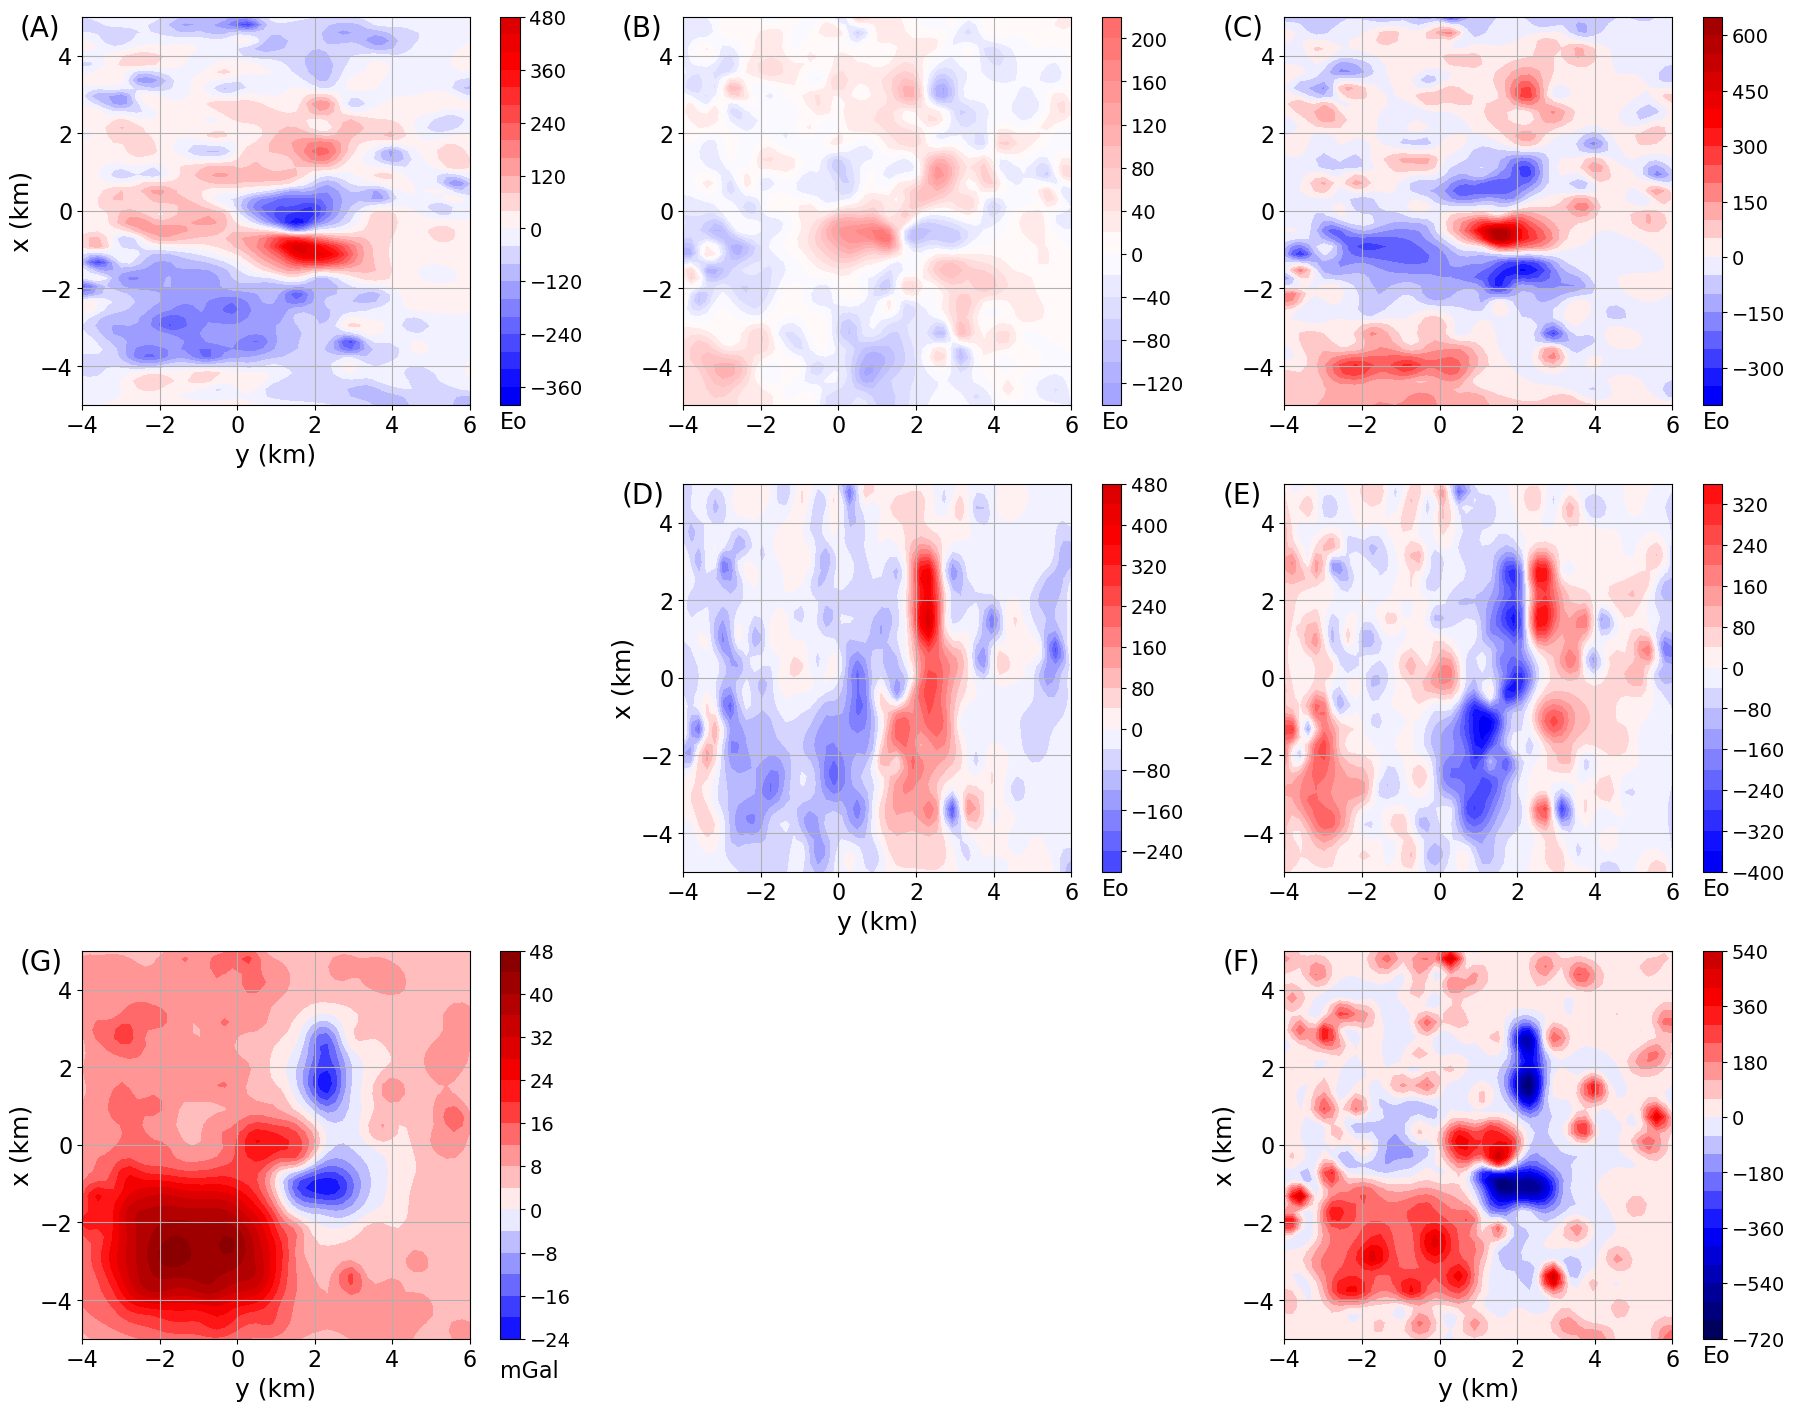

In [28]:
# plot figure
fig = plt.figure(layout= 'constrained', figsize=(18,14))
mosaic = fig.subplot_mosaic('''
                            abc
                            .de
                            g.f
                            ''')
# tensor components
for (element, tensor_component, label) in zip(
    mosaic_elements, tensor_components, labels
):
    ax = mosaic[element]
    ax.axis('scaled')
    im = ax.contourf(data_points['coordinates']['y'].reshape(data_points['shape'])*0.001, 
                     data_points['coordinates']['x'].reshape(data_points['shape'])*0.001, 
                     predicted_data['g{}'.format(tensor_component)].reshape(data_points['shape']), 20, 
                     cmap='seismic', vmin=-ranges_tensor, vmax=ranges_tensor)
    cb = fig.colorbar(im, ax=ax)
    cb.ax.tick_params(labelsize=14)
    cb.ax.set_xlabel('Eo', fontsize=16, loc='left')
    ax.set_ylim(0.001*data_points['area'][0], 0.001*data_points['area'][1])
    ax.set_xlim(0.001*data_points['area'][2], 0.001*data_points['area'][3])
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid()
    ax.annotate(label, xy=(-0.16, 0.95), xycoords='axes fraction', fontsize=20)

# gz
ax = mosaic['g']
ax.axis('scaled')
im = ax.contourf(data_points['coordinates']['y'].reshape(data_points['shape'])*0.001, 
                 data_points['coordinates']['x'].reshape(data_points['shape'])*0.001, 
                 predicted_data['gz'].reshape(data_points['shape']), 20, 
                 cmap='seismic', vmin=-ranges_gz, vmax=ranges_gz)
cb = fig.colorbar(im, ax=ax)
cb.ax.tick_params(labelsize=14)
cb.ax.set_xlabel('mGal', fontsize=16, loc='left', labelpad=15)
ax.set_ylim(0.001*data_points['area'][0], 0.001*data_points['area'][1])
ax.set_xlim(0.001*data_points['area'][2], 0.001*data_points['area'][3])
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid()
ax.annotate('(G)', xy=(-0.16, 0.95), xycoords='axes fraction', fontsize=20)

for element in ['a','d','f','g']:
    mosaic[element].set_ylabel('x (km)', fontsize=18)
    mosaic[element].set_xlabel('y (km)', fontsize=18)

#plt.savefig('../manuscript/Fig/C92_predicted.png', dpi= 300)
plt.show()

In [29]:
# compute ranges
ranges_gz = np.max(np.abs(residuals['gz']))
ranges_tensor = []
for tensor_component in tensor_components:
    ranges_tensor.append(np.max(np.abs(residuals['g{}'.format(tensor_component)])))
ranges_tensor = 0.9*np.max(ranges_tensor)

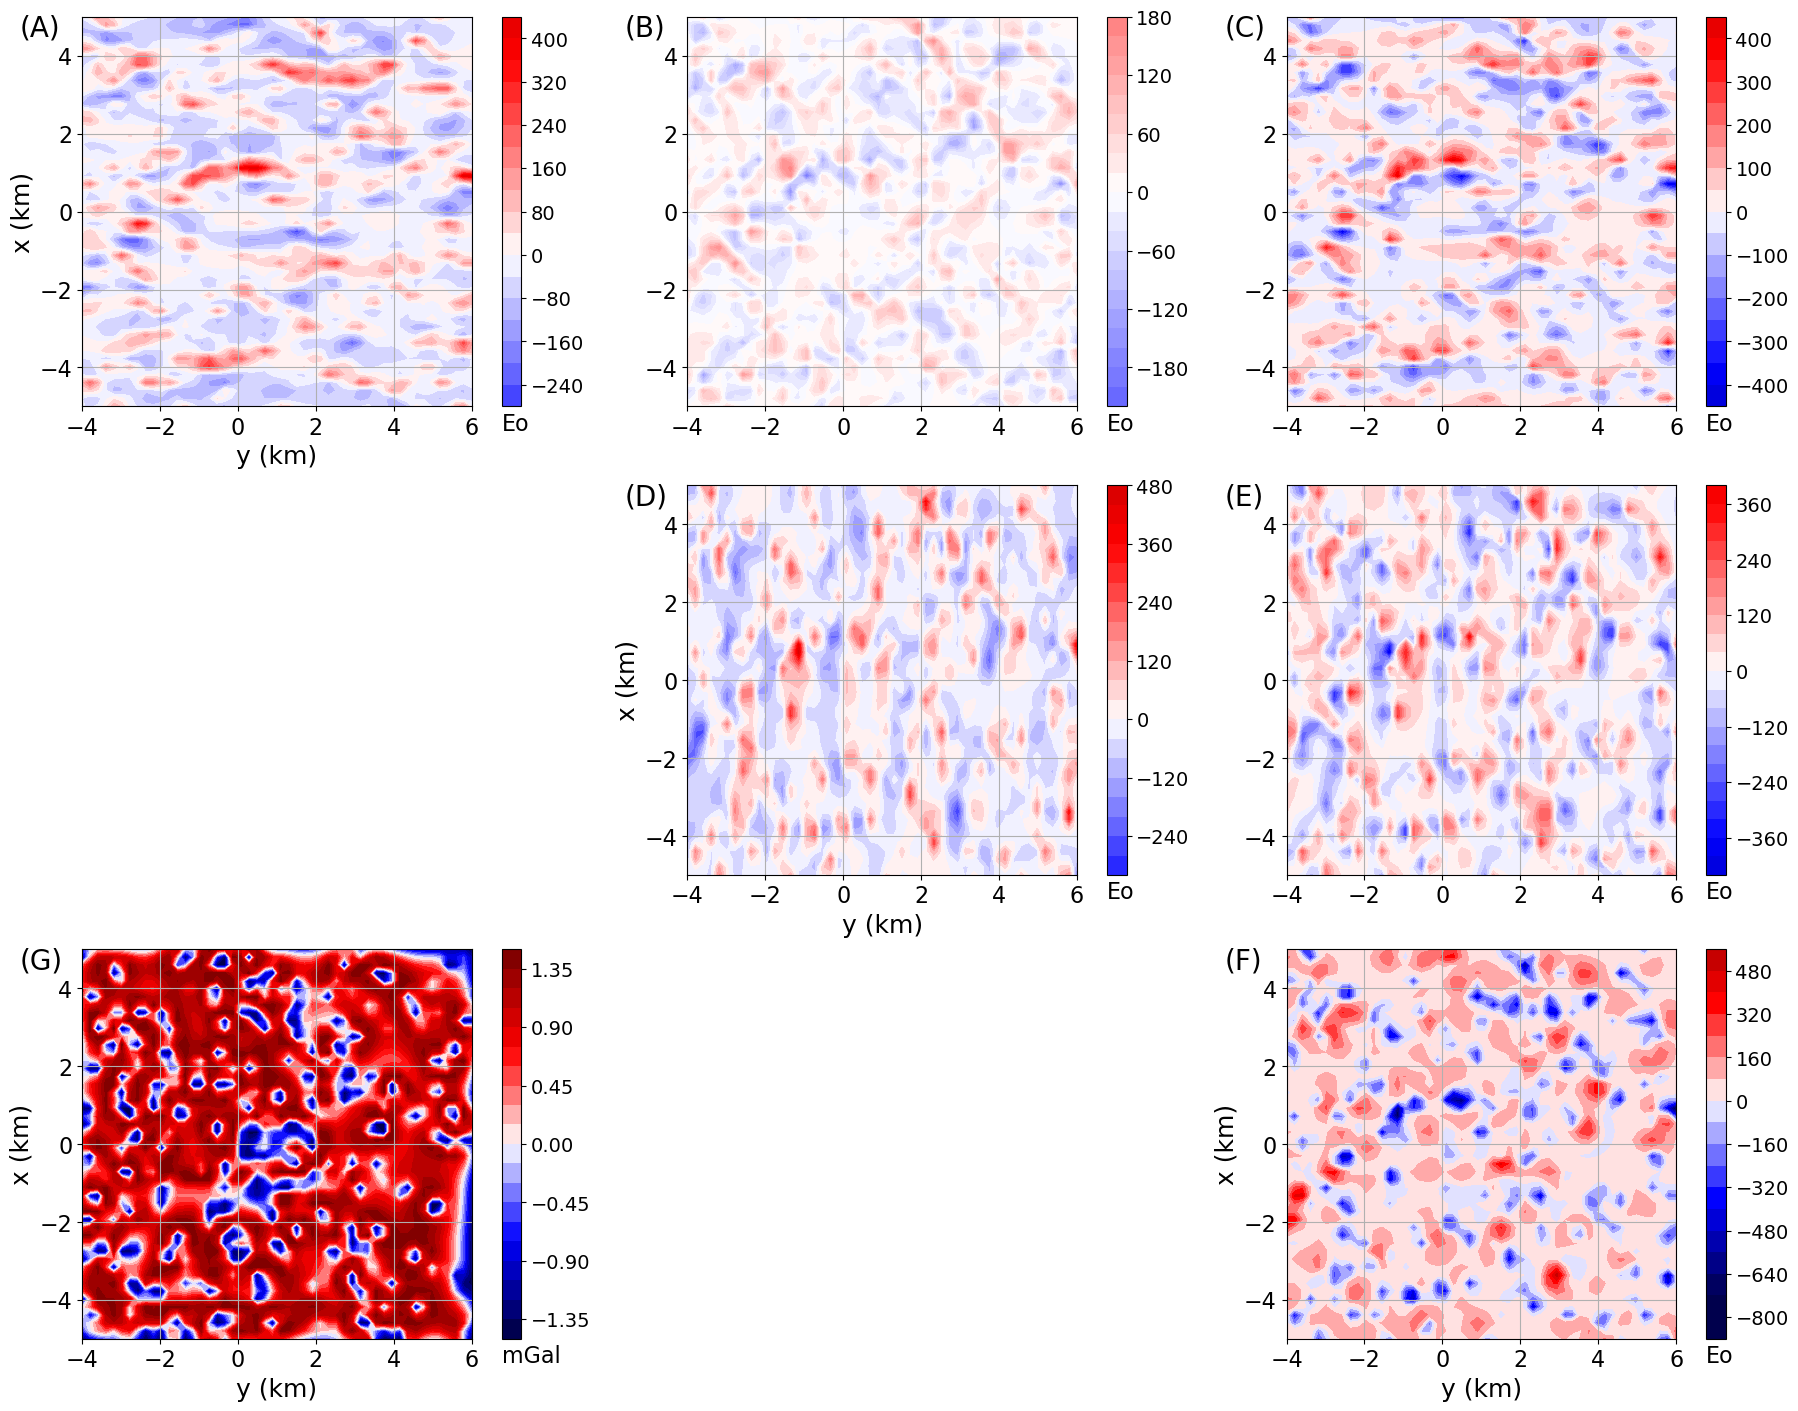

In [30]:
# plot figure
fig = plt.figure(layout= 'constrained', figsize=(18,14))
mosaic = fig.subplot_mosaic('''
                            abc
                            .de
                            g.f
                            ''')
# tensor components
for (element, tensor_component, label) in zip(
    mosaic_elements, tensor_components, labels
):
    ax = mosaic[element]
    ax.axis('scaled')
    im = ax.contourf(data_points['coordinates']['y'].reshape(data_points['shape'])*0.001, 
                     data_points['coordinates']['x'].reshape(data_points['shape'])*0.001, 
                     residuals['g{}'.format(tensor_component)].reshape(data_points['shape']), 20, 
                     cmap='seismic', vmin=-ranges_tensor, vmax=ranges_tensor)
    cb = fig.colorbar(im, ax=ax)
    cb.ax.tick_params(labelsize=14)
    cb.ax.set_xlabel('Eo', fontsize=16, loc='left')
    ax.set_ylim(0.001*data_points['area'][0], 0.001*data_points['area'][1])
    ax.set_xlim(0.001*data_points['area'][2], 0.001*data_points['area'][3])
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid()
    ax.annotate(label, xy=(-0.16, 0.95), xycoords='axes fraction', fontsize=20)

# gz
ax = mosaic['g']
ax.axis('scaled')
im = ax.contourf(data_points['coordinates']['y'].reshape(data_points['shape'])*0.001, 
                 data_points['coordinates']['x'].reshape(data_points['shape'])*0.001, 
                 residuals['gz'].reshape(data_points['shape']), 20, 
                 cmap='seismic', vmin=-ranges_gz, vmax=ranges_gz)
cb = fig.colorbar(im, ax=ax)
cb.ax.tick_params(labelsize=14)
cb.ax.set_xlabel('mGal', fontsize=16, loc='left')
ax.set_ylim(0.001*data_points['area'][0], 0.001*data_points['area'][1])
ax.set_xlim(0.001*data_points['area'][2], 0.001*data_points['area'][3])
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid()
ax.annotate('(G)', xy=(-0.16, 0.95), xycoords='axes fraction', fontsize=20)

for element in ['a','d','f','g']:
    mosaic[element].set_ylabel('x (km)', fontsize=18)
    mosaic[element].set_xlabel('y (km)', fontsize=18)

#plt.savefig('../manuscript/Fig/C92_residuals.png', dpi= 300)
plt.show()

In [31]:
# compute mean and standard deviation
mean_gz = np.mean(residuals['gz'])
std_gz = np.std(residuals['gz'])

In [32]:
# compute mean and standard deviation
means_tensor = []
stds_tensor = []
for tensor_component in tensor_components:
    means_tensor.append(
        np.mean(residuals['g{}'.format(tensor_component)])
    )
    stds_tensor.append(
        np.std(residuals['g{}'.format(tensor_component)])
    )

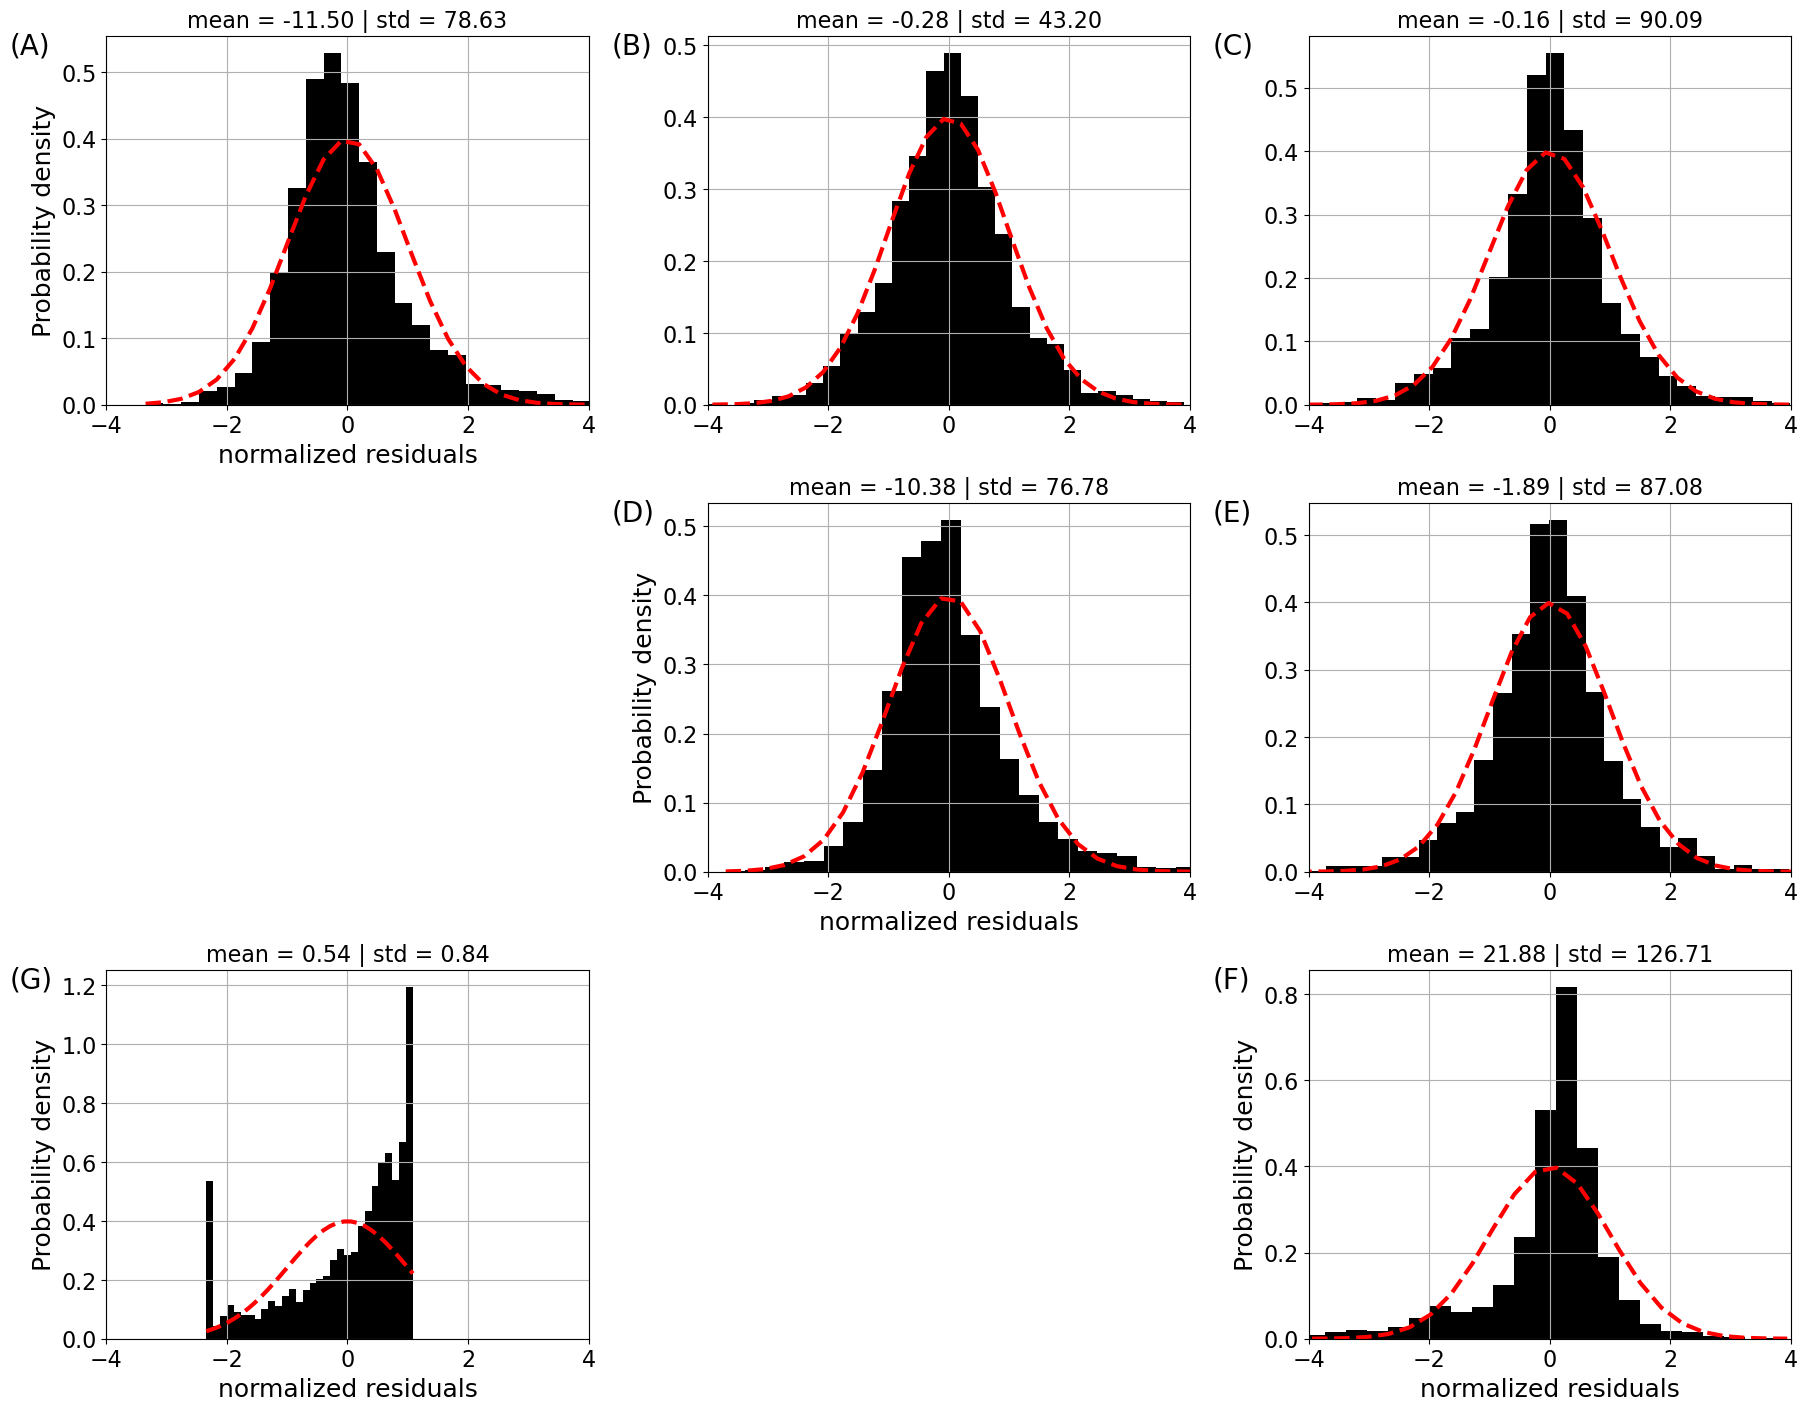

In [33]:
# plot histograms

num_bins = 30


fig = plt.figure(layout= 'constrained', figsize=(18,14))
mosaic = fig.subplot_mosaic('''
                            abc
                            .de
                            g.f
                            ''')
# tensor components
for (element, tensor_component, label, mean, std) in zip(
    mosaic_elements, tensor_components, labels, means_tensor, stds_tensor
):
    ax = mosaic[element]
    # the histogram of the data
    n, bins, patches = ax.hist(
        (residuals['g{}'.format(tensor_component)] - mean)/std, 
        num_bins, density=True, color='black'
    )
    # add a 'best fit' line
    best_fit = (
        (1 / (np.sqrt(2 * np.pi))) * np.exp(-0.5 * (bins)**2)
    )
    ax.plot(bins, best_fit, 'r--', linewidth=3)
    ax.set_title('mean = {:.2f} | std = {:.2f}'.format(mean, std), fontsize=16)
    ax.set_xlim(-4, 4)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid()
    ax.annotate(label, xy=(-0.20, 0.95), xycoords='axes fraction', fontsize=20)

# gz
ax = mosaic['g']
# the histogram of the data
n, bins, patches = ax.hist(
    (residuals['gz'] - mean_gz)/std_gz, 
    num_bins, density=True, color='black'
)
# add a 'best fit' line
best_fit = (
    (1 / (np.sqrt(2 * np.pi))) * np.exp(-0.5 * (bins)**2)
)
ax.plot(bins, best_fit, 'r--', linewidth=3)
ax.set_title('mean = {:.2f} | std = {:.2f}'.format(mean_gz, std_gz), fontsize=16)
ax.set_xlim(-4, 4)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid()
ax.annotate('(G)', xy=(-0.20, 0.95), xycoords='axes fraction', fontsize=20)

for element in ['a','d','f','g']:
    mosaic[element].set_ylabel('Probability density', fontsize=18)
    mosaic[element].set_xlabel('normalized residuals', fontsize=18)

#plt.savefig('../manuscript/Fig/C92_histograms.png', dpi= 300)
plt.show()